### Moving Average Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
t = np.linspace(0, 1, 500)
clean_signal = np.sin(2 * np.pi * 5 * t)
noise = np.random.normal(0, 0.5, 500)
x = clean_signal + noise

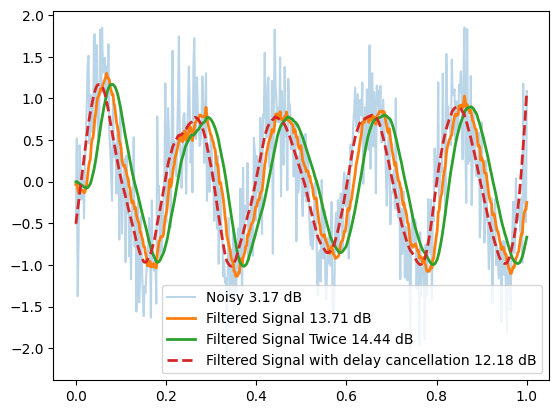

In [3]:
# Filter Setup
M = 15 #window size
b = np.ones(M) / M #num
a = 1 #den

y = signal.lfilter(b, a, x)
z = signal.lfilter(b, a, y)
y_nd = signal.filtfilt(b, a, x)

def get_snr(clean, filtered):
    noise_est = clean - filtered
    snr = 10 * np.log10(np.sum(clean**2) / np.sum(noise_est**2))
    return snr

# snr is calculated by aligning the signal to remove group delay
delay_single = (M-1)//2
delay_double = M - 1

snr_x = get_snr(clean_signal, x)
snr_y = get_snr(clean_signal[:-delay_single], y[delay_single:])
snr_z = get_snr(clean_signal[:-delay_double], z[delay_double:])
snr_y_nd = get_snr(clean_signal, y_nd)

plt.plot(t, x, label=f"Noisy {snr_x:.2f} dB", alpha=0.3)
plt.plot(t, y, label=f"Filtered Signal {snr_y:.2f} dB", linewidth=2)
plt.plot(t, z, label=f"Filtered Signal Twice {snr_z:.2f} dB", linewidth=2)
plt.plot(t, y_nd, label=f"Filtered Signal with delay cancellation {snr_y_nd:.2f} dB", linewidth=2, linestyle='--')
plt.legend()
plt.show()

The moving average filter introduces the phase delay in the frequencies. The phase response is linear so each freq component gets shifted by same amount of time delay.

Group delay of (M-1)/2 where M is the window size

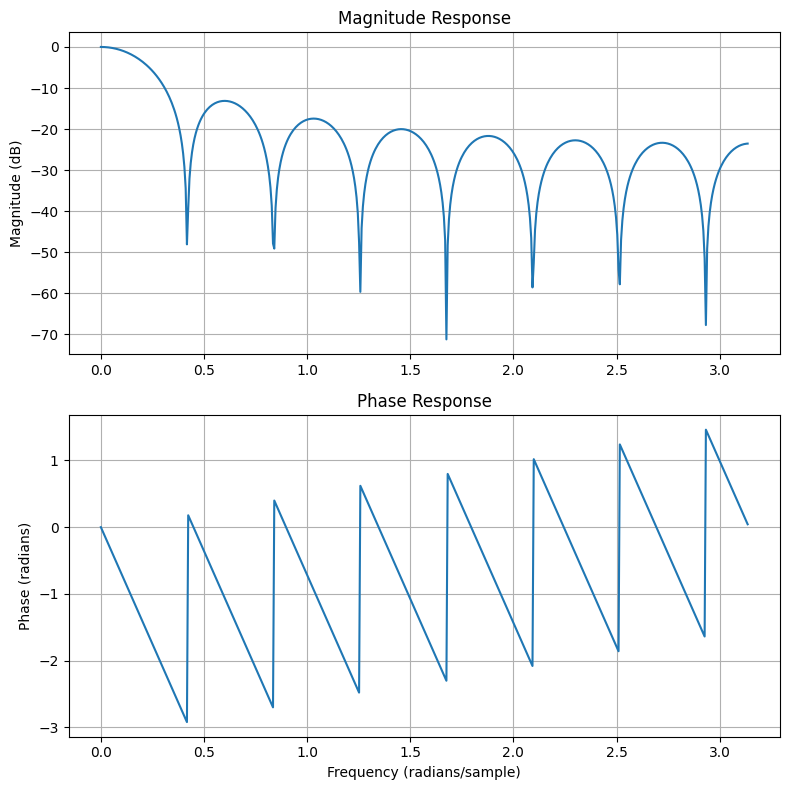

In [4]:
#frequency reponse
w,h = signal.freqz(b,a)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Magnitude Response (dB)
ax1.plot(w, 20 * np.log10(np.abs(h) + 1e-12))
ax1.set_title("Magnitude Response")
ax1.set_ylabel("Magnitude (dB)")
ax1.grid()

# Phase Response (Radians)
ax2.plot(w, np.angle(h))
ax2.set_title("Phase Response")
ax2.set_xlabel("Frequency (radians/sample)")
ax2.set_ylabel("Phase (radians)")
ax2.grid()

plt.tight_layout()
plt.show()

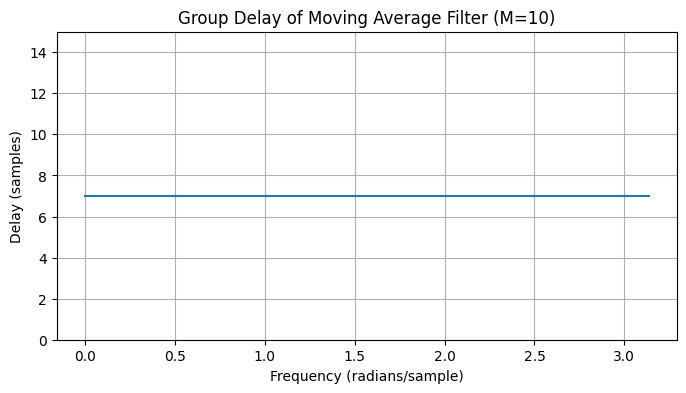

In [5]:
w, gd = signal.group_delay((b, a))

plt.figure(figsize=(8, 4))
plt.plot(w, gd)
plt.title("Group Delay of Moving Average Filter (M=10)")
plt.xlabel("Frequency (radians/sample)")
plt.ylabel("Delay (samples)")
plt.ylim(0, M)
plt.grid()
plt.show()

### Weighted Moving Average

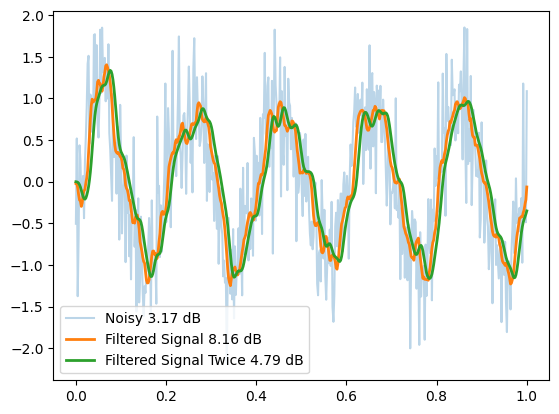

In [6]:
# Filter Setup

M = 9 #window size

#WEIGHTS
w = [1,2,3,4,5,4,3,2,1] #if weights are symmetric then phase response is linear otherwise non linear
w = w/np.sum(w)
b = w[::-1] #num
a = 1 #den

y = signal.lfilter(b,a,x)
z = signal.lfilter(b,a,y)

snr_y = get_snr(clean_signal, y)
snr_z = get_snr(clean_signal, z)

plt.plot(t, x, label=f"Noisy {snr_x:.2f} dB", alpha=0.3)
plt.plot(t, y, label=f"Filtered Signal {snr_y:.2f} dB", linewidth=2)
plt.plot(t, z, label=f"Filtered Signal Twice {snr_z:.2f} dB", linewidth=2)
plt.legend()
plt.show()

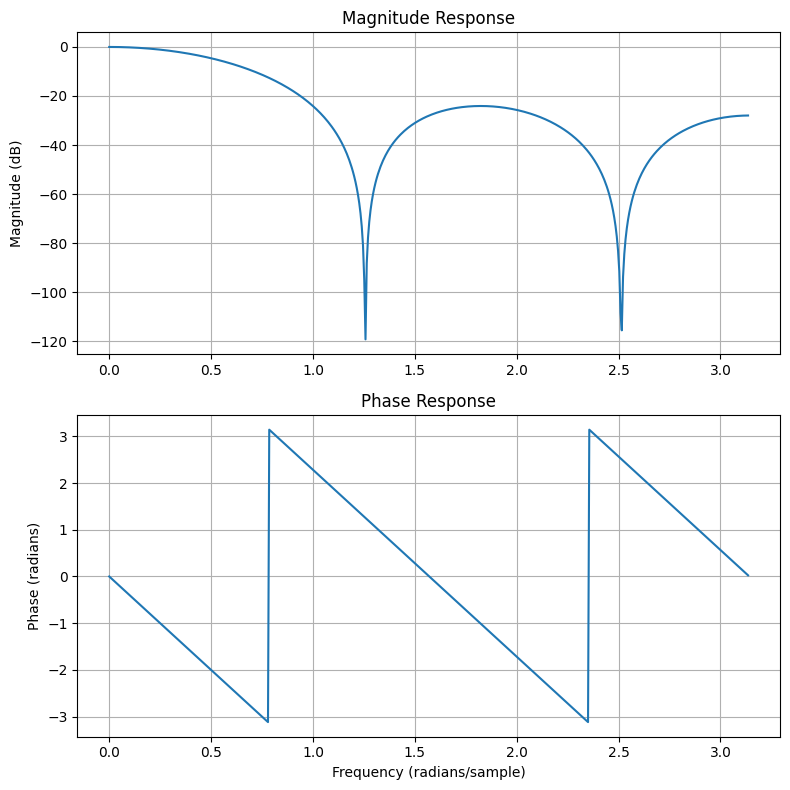

In [7]:
#frequency reponse
w,h = signal.freqz(b,a)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Magnitude Response (dB)
ax1.plot(w, 20 * np.log10(np.abs(h) + 1e-12))
ax1.set_title("Magnitude Response")
ax1.set_ylabel("Magnitude (dB)")
ax1.grid()

# Phase Response (Radians)
ax2.plot(w, np.angle(h))
ax2.set_title("Phase Response")
ax2.set_xlabel("Frequency (radians/sample)")
ax2.set_ylabel("Phase (radians)")
ax2.grid()

plt.tight_layout()
plt.show()

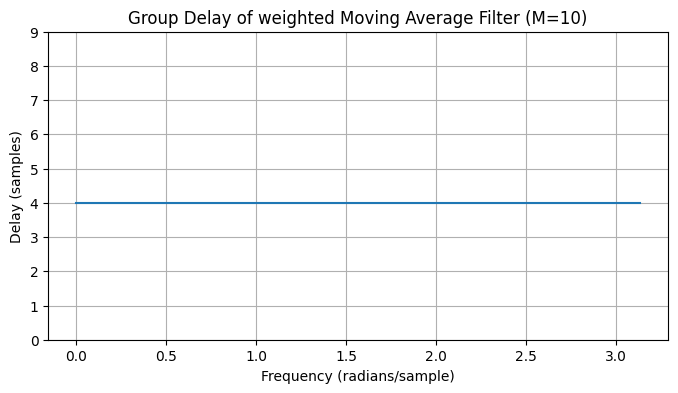

In [8]:
w, gd = signal.group_delay((b, a))

plt.figure(figsize=(8, 4))
plt.plot(w, gd)
plt.title("Group Delay of weighted Moving Average Filter (M=10)")
plt.xlabel("Frequency (radians/sample)")
plt.ylabel("Delay (samples)")
plt.ylim(0, M)
plt.grid()
plt.show()

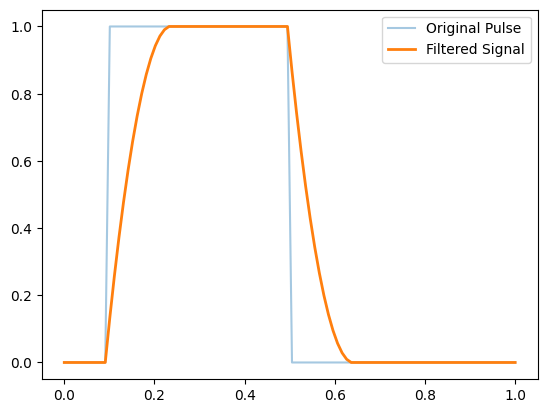

In [9]:
t = np.linspace(0, 1, 100)
x = np.zeros(100)
x[10:50] = 1.0  # sharp rectangular pulse

# Filter Setup
M = 15 #window size

#WEIGHTS
w = np.arange(M) #if weights are asymmetric then phase response is non linear so is non constant group delay
w = w/np.sum(w)
b = w[::-1] #num
a = 1 #den

y = signal.lfilter(b,a,x)


plt.plot(t, x, label=f"Original Pulse", alpha=0.4)
plt.plot(t, y, label=f"Filtered Signal", linewidth=2)
plt.legend()
plt.show()

The pulse gets spreaded in time due to asymmetric weights

### Exponential Moving Average Filter

In [12]:
def get_optimized_snr(ref, noisy):
    ref_c = ref - np.mean(ref)
    noisy_c = noisy - np.mean(noisy)
    
    # Cross-correlation alignment
    corr = signal.correlate(noisy_c, ref_c, mode='full')
    lags = signal.correlation_lags(noisy_c.size, ref_c.size, mode='full')
    lag = lags[np.argmax(np.abs(corr))]
    
    # Apply lag shift
    if lag > 0:
        noisy_final = noisy_c[lag:]
        ref_final = ref_c[:len(noisy_final)]
    else:
        ref_final = ref_c[-lag:]
        noisy_final = noisy_c[:len(ref_final)]
        
    # Match lengths
    length = min(len(ref_final), len(noisy_final))
    ref_final, noisy_final = ref_final[:length], noisy_final[:length]
    
    # SNR Calculation
    p_signal = np.mean(ref_final**2)
    p_noise = np.mean((noisy_final - ref_final)**2)
    
    return 10 * np.log10(p_signal / p_noise) if p_noise > 0 else float('inf')

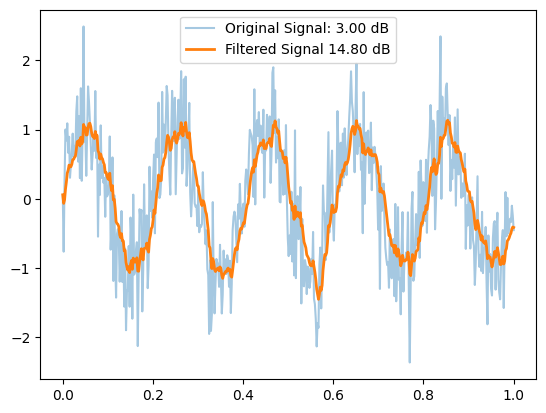

In [28]:
t = np.linspace(0, 1, 500)
clean_signal = np.sin(2 * np.pi * 5 * t)
noise = np.random.normal(0, 0.5, 500)
x = clean_signal + noise

ema_filtered= np.zeros_like(x)
ema_filtered[0] = x[0]
alpha = 0.15

for n in range (1, len(x)):
    ema_filtered[n] = alpha * x[n] + (1-alpha) * ema_filtered[n-1]

snr_x = get_optimized_snr(clean_signal, x)
snr_filtered = get_optimized_snr(clean_signal,ema_filtered)

plt.plot(t, x, label=f"Original Signal: {snr_x:.2f} dB", alpha=0.4)
plt.plot(t, ema_filtered, label=f"Filtered Signal {snr_filtered:.2f} dB", linewidth=2)
plt.legend()
plt.show()

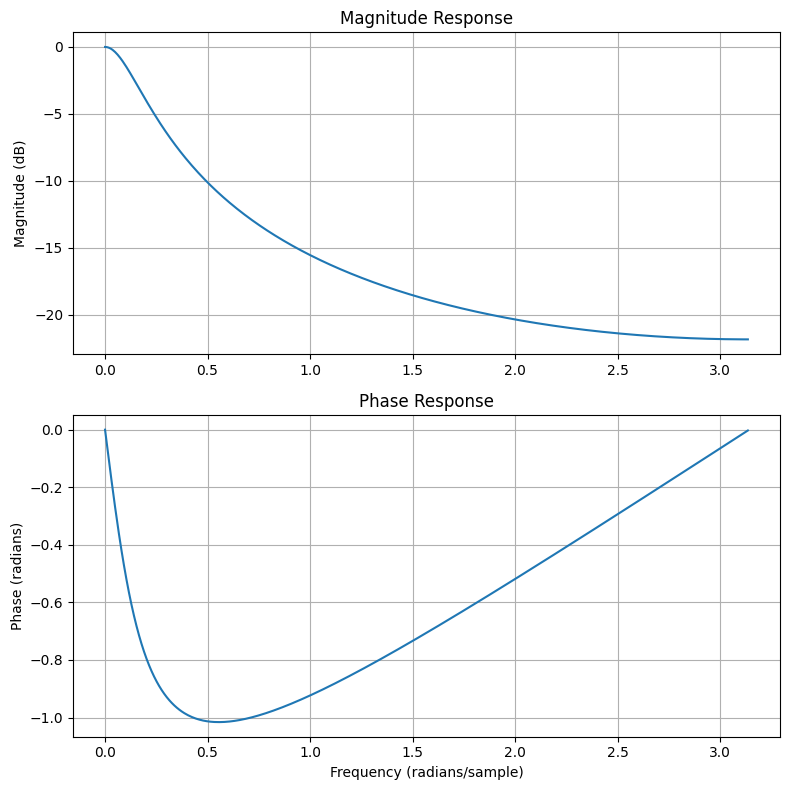

In [21]:
b = [alpha]
a= [1, -(1-alpha)]

#frequency reponse
w,h = signal.freqz(b,a)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Magnitude Response (dB)
ax1.plot(w, 20 * np.log10(np.abs(h) + 1e-12))
ax1.set_title("Magnitude Response")
ax1.set_ylabel("Magnitude (dB)")
ax1.grid()

# Phase Response (Radians)
ax2.plot(w, np.angle(h))
ax2.set_title("Phase Response")
ax2.set_xlabel("Frequency (radians/sample)")
ax2.set_ylabel("Phase (radians)")
ax2.grid()

plt.tight_layout()
plt.show()

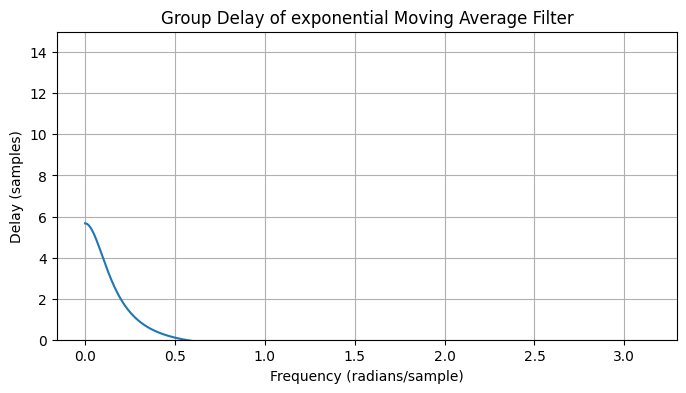

In [23]:
w, gd = signal.group_delay((b, a))

plt.figure(figsize=(8, 4))
plt.plot(w, gd)
plt.title("Group Delay of exponential Moving Average Filter")
plt.xlabel("Frequency (radians/sample)")
plt.ylabel("Delay (samples)")
plt.ylim(0, M)
plt.grid()
plt.show()